In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
import numpy as np
from tensorflow.keras.preprocessing import image
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, accuracy_score
from google.colab import drive

In [2]:
drive.mount('/content/drive')
data_dir_train = "/content/drive/My Drive/DATASET/Tomato/train"
data_dir_val = "/content/drive/My Drive/DATASET/Tomato/val"
data_dir_test = "/content/drive/My Drive/DATASET/Tomato/test"

IMG_SIZE = (256, 256)
BATCH_SIZE = 32
NUM_CLASSES = 5

INITIAL_EPOCHS = 6
FINETUNE_EPOCHS = 8
TOTAL_EPOCHS = INITIAL_EPOCHS + FINETUNE_EPOCHS

AUTOTUNE = tf.data.AUTOTUNE
SEED = 42

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_val,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=SEED
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=SEED
)

class_names = train_ds.class_names
print("Class names:", class_names)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 2800 files belonging to 5 classes.
Found 800 files belonging to 5 classes.
Found 400 files belonging to 5 classes.
Class names: ['Blight', 'Healthy', 'Leaf_Mold', 'Spider_Mites', 'Yellow_Leaf_Curl_Virus']


In [3]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.06),
    layers.RandomZoom(0.08),
    layers.RandomTranslation(0.04, 0.04),
], name="data_augmentation")

preprocess_input = tf.keras.applications.efficientnet.preprocess_input

def augment_and_preprocess(images, labels):
    images = tf.cast(images, tf.float32)
    images = data_augmentation(images)
    images = preprocess_input(images)
    return images, labels

def preprocess_only(images, labels):
    images = tf.cast(images, tf.float32)
    images = preprocess_input(images)
    return images, labels

train_ds = train_ds.map(augment_and_preprocess, num_parallel_calls=AUTOTUNE)
val_ds   = val_ds.map(preprocess_only, num_parallel_calls=AUTOTUNE)
test_ds  = test_ds.map(preprocess_only, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.cache().shuffle(2048).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [4]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(*IMG_SIZE, 3)
)
base_model.trainable = False

inputs = Input(shape=(*IMG_SIZE,3))
x = inputs
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.2)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs, outputs, name="efficientnetb0_transfer")
model.summary()

Model: "efficientnetb0_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,792 (16.70 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [5]:
initial_lr = 1e-3
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [6]:
history_frozen = model.fit(
    train_ds,
    epochs=INITIAL_EPOCHS,
    validation_data=val_ds
)

Epoch 1/6
88/88 ━━━━━━━━━━━━━━━━━━━━ 112s 363ms/step - accuracy: 0.6766 - loss: 0.8220 - val_accuracy: 0.9475 - val_loss: 0.1620
Epoch 2/6
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9368 - loss: 0.1881 - val_accuracy: 0.9588 - val_loss: 0.1124
Epoch 3/6
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9481 - loss: 0.1505 - val_accuracy: 0.9650 - val_loss: 0.1025
Epoch 4/6
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9668 - loss: 0.1038 - val_accuracy: 0.9262 - val_loss: 0.1919
Epoch 5/6
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9700 - loss: 0.0829 - val_accuracy: 0.9762 - val_loss: 0.0712
Epoch 6/6
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9781 - loss: 0.0713 - val_accuracy: 0.9625 - val_loss: 0.0957


In [7]:
base_model.trainable = True
for layer in base_model.layers[:-15]:
    layer.trainable = False
for layer in base_model.layers[-15:]:
    layer.trainable = True

fine_tune_lr = 1e-5
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

trainable_count = sum(tf.keras.backend.count_params(w) for w in model.trainable_weights)
total_params = sum(tf.keras.backend.count_params(w) for w in model.weights)
print(f"Trainable params: {trainable_count:,} / Total params: {total_params:,}")

Trainable params: 1,237,429 / Total params: 4,378,792.0


In [8]:
history_finetune = model.fit(
    train_ds,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history_frozen.epoch[-1] + 1,
    validation_data=val_ds
)

Epoch 7/14
88/88 ━━━━━━━━━━━━━━━━━━━━ 52s 297ms/step - accuracy: 0.8182 - loss: 0.5154 - val_accuracy: 0.9563 - val_loss: 0.1055
Epoch 8/14
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9051 - loss: 0.2901 - val_accuracy: 0.9650 - val_loss: 0.1016
Epoch 9/14
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9233 - loss: 0.2286 - val_accuracy: 0.9663 - val_loss: 0.1085
Epoch 10/14
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9466 - loss: 0.1790 - val_accuracy: 0.9675 - val_loss: 0.1100
Epoch 11/14
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9550 - loss: 0.1532 - val_accuracy: 0.9688 - val_loss: 0.1099
Epoch 12/14
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9641 - loss: 0.1436 - val_accuracy: 0.9663 - val_loss: 0.1097
Epoch 13/14
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9711 - loss: 0.1198 - val_accuracy: 0.9700 - val_loss: 0.1021
Epoch 14/14
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9677 - loss: 0.1203 - val_accuracy: 0.9

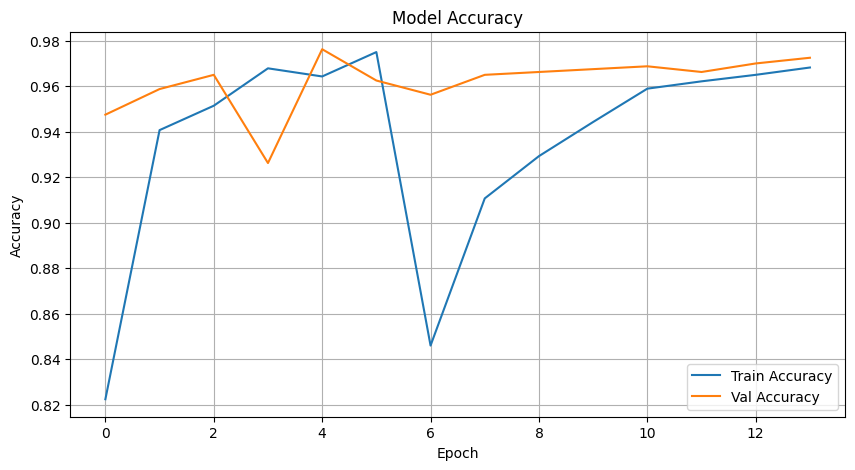

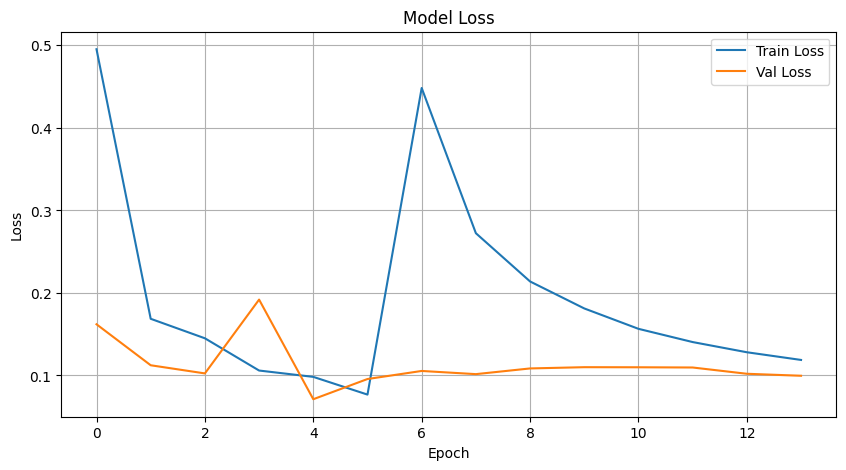

Best Val Accuracy: 0.9762 at epoch 5


In [9]:
def combine_history(h1, h2):
    history = {}
    for key in h1.history.keys():
        history[key] = h1.history[key] + h2.history.get(key, [])
    return history

full_history = combine_history(history_frozen, history_finetune)

plt.figure(figsize=(10, 5))
plt.plot(full_history["accuracy"], label="Train Accuracy")
plt.plot(full_history["val_accuracy"], label="Val Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(full_history["loss"], label="Train Loss")
plt.plot(full_history["val_loss"], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

best_val_acc = max(full_history["val_accuracy"])
best_epoch = np.argmax(full_history["val_accuracy"]) + 1
print(f"Best Val Accuracy: {best_val_acc:.4f} at epoch {best_epoch}")


In [10]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\nDETAILED METRICS:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 483ms/step - accuracy: 0.9734 - loss: 0.0867
Test Accuracy: 0.9700
Test Loss: 0.0916

DETAILED METRICS:
Accuracy:  0.9700
Precision: 0.9712
Recall:    0.9700
F1-Score:  0.9700



CLASSIFICATION REPORT:
                        precision    recall  f1-score   support

                Blight       1.00      0.97      0.99        80
               Healthy       0.96      1.00      0.98        80
             Leaf_Mold       0.97      0.91      0.94        80
          Spider_Mites       0.92      0.99      0.95        80
Yellow_Leaf_Curl_Virus       1.00      0.97      0.99        80

              accuracy                           0.97       400
             macro avg       0.97      0.97      0.97       400
          weighted avg       0.97      0.97      0.97       400



<Figure size 1000x800 with 0 Axes>

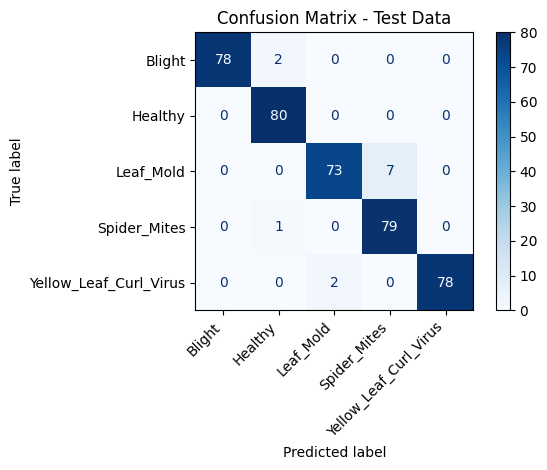

In [11]:
print("\nCLASSIFICATION REPORT:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(10, 8))
disp.plot(cmap="Blues", values_format="d")
plt.xticks(rotation=45, ha='right')
plt.title("Confusion Matrix - Test Data")
plt.tight_layout()
plt.show()

In [12]:
model.save('tomato_disease_efficientnet.keras')
print("\nModel saved as 'tomato_disease_efficientnet.keras'")


Model saved as 'tomato_disease_efficientnet.keras'
